# <span style='color:SteelBlue'>CRC - BONS RADIO SCANNER / IRM / ARC</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [ ]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

**BUT**
*****
- **Récupérer les bons SCANNER** du formulaire DEMSCANNV après la date de démarrage souhaitée.
- **Récupérer les bons IRM** du formulaire DEMIRM après la date de démarrage souhaitée.
- **Récupérer les bons ARC** du formulaire ??? après la date de démarrage souhaitée.
- **Concataner les bons SCANNER+IRM+ARC** exporter en XLSX dans un répertoire partagée et ajouter une mise en forme conditionnelle.

In [122]:
# Chargement des librairies
import sys
import os
# import jyquickhelper
import time
import pandas as pd
import numpy as np
from datetime import datetime
import shutil
# Connexion jdbc sqlserver
import pyodbc
from sqlalchemy import create_engine
# Chargement des variables d'environnement
from dotenv import load_dotenv
# Chiffrement mot de passe
from cryptography.fernet import Fernet
# EXcel
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill, Font, Alignment
from openpyxl.worksheet.datavalidation import DataValidation
# Log
import logging
# Chargement à chaud des librairies personnelles
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Valide code pep8
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

In [123]:
# Versions 
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)

now  = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python        : 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
NumPy         : 1.24.3
Pandas        : 2.0.3
Lancé le           : 2025-06-12T13:50:25.947394


In [124]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [184]:
# --- CONFIGURATION DU LOGGER ---
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_path = os.path.join(rep_log, f"log_traitement_{timestamp}.log")

# Créer le logger
logger = logging.getLogger("fusion_recist")
logger.setLevel(logging.INFO)

# Formatter commun
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

# Handler fichier
file_handler = logging.FileHandler(log_path, encoding='utf-8')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Handler console
#console_handler = logging.StreamHandler()
#console_handler.setFormatter(formatter)
#logger.addHandler(console_handler)

logger.info("Démarrage du traitement RECIST")

2025-06-12 14:31:33,735 - INFO - Démarrage du traitement RECIST


## <span style='background:Thistle'>1. Connexion BDD BO SQLServer</span> 

In [4]:
# drivers installés?
print(pyodbc.drivers())

['SQL Server', 'PostgreSQL ANSI(x64)', 'PostgreSQL Unicode(x64)', 'PostgreSQL ANSI', 'PostgreSQL Unicode']


In [125]:
# Chargement des variables d'environnement
load_dotenv()

True

In [126]:
# Paramètres de connexion
server = os.getenv('SQLSERVER_HOST')
user = os.getenv('SQLSERVER_USER')
encrypted_password = os.getenv('SQLSERVER_PASSWORD_ENCRYPTED')
fernet_key = os.getenv('FERNET_KEY')
database = os.getenv('SQLSERVER_DB')

In [127]:
# Déchiffrer le mot de passe
fernet = Fernet(fernet_key.encode())
password = fernet.decrypt(encrypted_password.encode()).decode()

In [128]:
# Construction de l'URL SQLAlchemy
connection_url = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    "?driver=SQL+Server"
)

In [129]:
# Création de l'engine SQLAlchemy
engine = create_engine(connection_url)

## <span style='background:Thistle'>1. Récuparation des données de la BDD BO</span> 

In [130]:
# Répertoire des données en entrée
rep_in = "DATA/IN/"
# Répertoire des scripts SQL
rep_sql = "DATA/IN/SQL/"
# Créer le dossier s'il n'existe pas
os.makedirs(rep_in, exist_ok=True)
# Répertoire des données en sortie
rep_out = "DATA/OUT/"
# Créer le dossier s'il n'existe pas
os.makedirs(rep_out, exist_ok=True)
# Répertoire des logs des lignes ajoutées
rep_log = "DATA/OUT/LOG/"
# Créer le dossier s'il n'existe pas
os.makedirs(rep_log, exist_ok=True)
# Répertoire d'archive
rep_arch = "DATA/OUT/ARCHIVES/"
# Créer le dossier s'il n'existe pas
os.makedirs(rep_arch, exist_ok=True)

### <span style='background:PowderBlue'>1.1. Chargement des bons de SCANNER RECIST</span>

In [131]:
# Lire la requête SQL depuis un fichier
with open(rep_sql+'BO-SELECT-FORM_DEMSCANNV.sql', 'r', encoding='utf-8') as file:
    sql_query = file.read()

In [132]:
# Exécuter la requête et récupérer dans un DataFrame des bon scanner
scan = pd.read_sql(sql_query, engine)

In [133]:
scan.head()

,DATE_DEMANDE_EXAMEN,DEMANDEUR_EXAMEN,NOM_POSTE_DEMANDEUR,NOM_PATIENT,PRENOM_PATIENT,IPP,ETUDE,DATE_LIMTE_RECIST,DATE_EXAMEN,TYPE_EXAMEN,LIEU_EXAMEN,TYPE_RELECTURE,DATE_BASELINE,DATE_EXAMEN_COMPARAISON,LIEN_VERS_CR,LIGNE_XPLORE,RELECTURE_REALISEE,RELECTURE_PAR,COMMENTAIRE
0,2025-06-11,Heloise BONNEVIALE,3749,MANDROU,CHRISTIAN,12307094,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
1,2025-06-11,Jean-David FUMET,3303,HALTER SANTINO,LAURIANNE,12504028,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
2,2025-06-11,Inès BRIATTE,3953,BAK,GERALDINE,12400985,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
3,2025-06-11,Hélène BELLIO,3403,CANOT,CHRISTIANE,12407713,,,,SCANNER,Examen CGFL,Baseline,,,,,NON,,
4,2025-06-10,Théo FOURRIER,3952,SALEMBIER,BRIGITTE,12404232,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,


In [134]:
# Taille : nombre de lignes/colonnes
nRow, nCol = scan.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 540 lignes et 19 colonnes.


### <span style='background:PowderBlue'>1.2. Chargement des bons de IRM RECIST</span>

In [135]:
# Lire la requête SQL depuis un fichier
with open(rep_sql+'BO-SELECT-FORM_DEMIRM.sql', 'r', encoding='utf-8') as file:
    sql_query = file.read()

In [136]:
# Exécuter la requête et récupérer dans un DataFrame des bon scanner
irm = pd.read_sql(sql_query, engine)

In [137]:
irm.head()

,DATE_DEMANDE_EXAMEN,DEMANDEUR_EXAMEN,NOM_POSTE_DEMANDEUR,NOM_PATIENT,PRENOM_PATIENT,IPP,ETUDE,DATE_LIMTE_RECIST,DATE_EXAMEN,TYPE_EXAMEN,LIEU_EXAMEN,TYPE_RELECTURE,DATE_BASELINE,DATE_EXAMEN_COMPARAISON,LIEN_VERS_CR,LIGNE_XPLORE,RELECTURE_REALISEE,RELECTURE_PAR,COMMENTAIRE
0,2025-06-06,Coureche-Guillaume K,3645,CHEVALIER,JEAN-LOUP,20227940,,,,IRM,Examen CGFL,Suivi Recist,,,,,NON,,
1,2025-06-03,Aurélie LAGRANGE,3643,FABERT,ELISE,12502096,,,,IRM,Examen CGFL,Suivi Recist,,,,,NON,,
2,2025-05-20,Théo FOURRIER,3952,PAULHAC,JACQUES,12502373,,,,IRM,Examen CGFL,Suivi Recist,,,,,NON,,
3,2025-05-15,Théo FOURRIER,3952,DUBRESSON,ROBERT,20153537,,,,IRM,Examen CGFL,Suivi Recist,,,,,NON,,
4,2025-05-09,Alexandra STEFAN,3132,DROUILLOT,MICHEL,12308928,,,,IRM,Examen CGFL,Suivi Recist,,,,,NON,,


In [138]:
# Taille : nombre de lignes/colonnes
nRow, nCol = irm.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 27 lignes et 19 colonnes.


### <span style='background:PowderBlue'>1.3. Chargement des bons SCANNER / IRM RECIST des ARCS</span>

## <span style='background:Thistle'>2. Concaténation des dataframes</span> 

### <span style='background:PowderBlue'>2.1. Concaténation SCANNER & IRM</span>

In [139]:
df_scan_irm = pd.concat([scan, irm], ignore_index=True)

In [140]:
# Taille : nombre de lignes/colonnes
nRow, nCol = df_scan_irm.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

Le jeu de données contient 567 lignes et 19 colonnes.


In [141]:
df_scan_irm.head()

,DATE_DEMANDE_EXAMEN,DEMANDEUR_EXAMEN,NOM_POSTE_DEMANDEUR,NOM_PATIENT,PRENOM_PATIENT,IPP,ETUDE,DATE_LIMTE_RECIST,DATE_EXAMEN,TYPE_EXAMEN,LIEU_EXAMEN,TYPE_RELECTURE,DATE_BASELINE,DATE_EXAMEN_COMPARAISON,LIEN_VERS_CR,LIGNE_XPLORE,RELECTURE_REALISEE,RELECTURE_PAR,COMMENTAIRE
0,2025-06-11,Heloise BONNEVIALE,3749,MANDROU,CHRISTIAN,12307094,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
1,2025-06-11,Jean-David FUMET,3303,HALTER SANTINO,LAURIANNE,12504028,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
2,2025-06-11,Inès BRIATTE,3953,BAK,GERALDINE,12400985,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,
3,2025-06-11,Hélène BELLIO,3403,CANOT,CHRISTIANE,12407713,,,,SCANNER,Examen CGFL,Baseline,,,,,NON,,
4,2025-06-10,Théo FOURRIER,3952,SALEMBIER,BRIGITTE,12404232,,,,SCANNER,Examen CGFL,Suivi Recist,,,,,NON,,


In [142]:
# Nettoyage : remplace NaN par ""
df_scan_irm = df_scan_irm.replace('None', '')
df_scan_irm = df_scan_irm.fillna('')

### <span style='background:PowderBlue'>2.2. Concaténation SCAN+IRM & ARC</span>

In [ ]:
df_all = pd.concat([df_scan_irm, arc], ignore_index=True)

In [ ]:
# Taille : nombre de lignes/colonnes
nRow, nCol = df_all.shape
print(f'Le jeu de données contient {nRow} lignes et {nCol} colonnes.')

In [ ]:
df_all.head()

In [ ]:
# Nettoyage : remplace NaN par ""
df_all = df_all.replace('None', '')
df_all = df_all.fillna('')

## <span style='background:Thistle'>3. Exports en XLSX</span> 

In [186]:
# Sauvegarder en .xlsx
df_scan_irm.to_excel(rep_out+"RECIST2.xlsx",
                     sheet_name='RECIST', index=False) 

In [ ]:
# Sauvegarder en .xlsx
df_all.to_excel(rep_out+"RECIST2.xlsx",
                sheet_name='RECIST', index=False) 

## <span style='background:Thistle'>4. Récupération du fichier de suivi RECIST.xlsx</span> 

In [187]:
# Fichiers d'entrée
file1 = 'RECIST.xlsx'
file2 = 'RECIST2.xlsx'

In [188]:
# Clé d'identification unique
key_columns = ['IPP', 'DATE_DEMANDE_EXAMEN', 'TYPE_EXAMEN']

In [189]:
# Lire toutes les feuilles des deux fichiers
recist1_sheets = pd.read_excel(rep_out+file1, sheet_name=None)
recist2_sheets = pd.read_excel(rep_out+file2, sheet_name=None)

In [ ]:
# -------------- VARIABLES STATICS --------------
# Pour stocker les feuilles fusionnées
merged_sheets = {}

# -------------- LOGS --------------
# Pour stocker les nouvelles lignes ajoutées (pour le log)
log_entries = []

# Générer un nom de fichier avec horodatage
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_filename = f"log_lignes_ajoutees_{timestamp}.csv"

# -------------- STYLES --------------
# Définir les couleurs des cellules d'entête
fill_vert = PatternFill(start_color="70AD47", end_color="70AD47", fill_type="solid")  # vert
fill_orange = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")  # orange
fill_bleu = PatternFill(start_color="2F75B5", end_color="2F75B5", fill_type="solid")  # bleu
# Définir la couleur de la police des colonnes d'entête
font_blanc = Font(color="FFFFFF", bold=True)  # police blanche et en gras

# Entêtes à colorer
entetes_vert = ["DATE_DEMANDE_EXAMEN", "DEMANDEUR_EXAMEN", "NOM_POSTE_DEMANDEUR", "NOM_PATIENT",
                 "PRENOM_PATIENT", "IPP", "ETUDE", "DATE_LIMTE_RECIST", "TYPE_EXAMEN", "LIEU_EXAMEN",
                 "TYPE_RELECTURE", "DATE_BASELINE", "DATE_EXAMEN_COMPARAISON", "LIEN_VERS_CR", "LIGNE_XPLORE",
                 "COMMENTAIRE"]
entetes_orange = ["RELECTURE_REALISEE", "RELECTURE_PAR"]
entetes_bleu = ["DATE_EXAMEN"]

# Définir l'alignement à gauche
alignement_gauche = Alignment(horizontal="left", vertical="center")

# Définir le style rouge clair pour la mise en forme conditionnelle
red_fill = PatternFill(start_color='FFCCCC', end_color='FFCCCC', fill_type='solid')

# -------------- FICHIERS ET REPERTOIRE DE TRAVAIL --------------
# Fichier RECIST.xlsx
source_filename = "RECIST.xlsx"
source_file_path = os.path.join(rep_out, source_filename)
# Fichier RECISTS_FUSIONNES.xlsx
fusion_filename = "RECISTS_FUSIONNES.xlsx"
fusion_file_path = os.path.join(rep_out, fusion_filename)
# Fichier   RECIST.xlsx archivé
archived_filename = f"RECIST_{timestamp}.xlsx"
archived_file_path = os.path.join(rep_arch, archived_filename)

# Liste des colonnes cibles pour rendre au format DD/MM/YYYY
colonnes_date = [
    "DATE_DEMANDE_EXAMEN",
    "DATE_LIMTE_RECIST",
    "DATE_EXAMEN",
    "DATE_BASELINE",
    "DATE_EXAMEN_COMPARAISON"
]

# Colonnes modifiables (I, O, P, Q, R, S) ==> les autres protégées
# I = 9, O = 15, P = 16, Q = 17, R = 18, S = 19
colonnes_modifiables = [9, 15, 16, 17, 18, 19]

# Format de date souhaité
date_format = 'DD/MM/YYYY'


In [195]:
# ==========================================================================
# -------------- TRAITEMENT DE FUSION DES DATAFRAMES PAR CLES --------------
# ==========================================================================

# -------------- SAUVEGARDE du fichier RECIST.xlsx --------------
# Copier une sauvegarde du fichier RECIST.xlsx dans ARCHIVES avec date/heure
shutil.copy(source_file_path, archived_file_path)
logger.info(f"Fichier source archivé dans : {archived_file_path}")

# -------------- FUSION DES FICHIERS EXCELS --------------
# Fusion feuille par feuille
for sheet_name in recist1_sheets:
    df1 = recist1_sheets[sheet_name]
    df2 = recist2_sheets.get(sheet_name, pd.DataFrame(columns=df1.columns))  # vide si onglet absent

    # Clés pour comparaison
    df1_keys = df1[key_columns].apply(tuple, axis=1)
    df2_keys = df2[key_columns].apply(tuple, axis=1)

    # Trouver les nouvelles lignes dans df2
    new_rows = df2[~df2_keys.isin(df1_keys)]

    # Enregistrer dans le log avec nom d'onglet
    if not new_rows.empty:
        new_rows_log = new_rows.copy()
        new_rows_log.insert(0, 'FEUILLE', sheet_name)  # Ajouter nom de la feuille
        new_rows_log['HORODATAGE'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_entries.append(new_rows_log)

    # Fusion des données
    merged_df = pd.concat([df1, new_rows], ignore_index=True)
    merged_sheets[sheet_name] = merged_df

# Ajouter les feuilles présentes uniquement dans RECIST2
for sheet_name in recist2_sheets:
    if sheet_name not in merged_sheets:
        merged_sheets[sheet_name] = recist2_sheets[sheet_name]

# ======================================================================================
# -------------- TRI DU DATAFRAME ET TRANSFO EN UN FICHIER EXCEL FUSIONNE --------------
# ======================================================================================

# --- Enregistrement du fichier + tri par date d'examen descendantes ---
with pd.ExcelWriter(fusion_filename, engine="openpyxl") as writer:
    for sheet_name, df in merged_sheets.items():
        # Tri par la colonne DATE_DEMANDE_EXAMEN (en s'assurant qu'elle existe)
        if "DATE_DEMANDE_EXAMEN" in df.columns:
            try:
                df["DATE_DEMANDE_EXAMEN"] = pd.to_datetime(df["DATE_DEMANDE_EXAMEN"], errors='coerce')
                df = df.sort_values(by="DATE_DEMANDE_EXAMEN", ascending=False)
            except Exception as e:
                logger.error(f"[!] Erreur de tri dans {sheet_name} : {e}")
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# =========================================================================
# -------------- PERSONNALISATION DU FICHIER EXCEL FUSIONNE  --------------
# =========================================================================
        
# --- AJUSTER AUTOMATIQUEMENT DE LA LARGEUR DES COLONNES ---
# Chargement du fichier excel fusionné
wb = load_workbook(fusion_filename)

for sheet in wb.worksheets:
    
    # Lire l'en-tête (ligne 1)
    header = [cell.value for cell in sheet[1]]
        
    # --------------  Figer la première ligne --------------
    sheet.freeze_panes = "A2"

    # --------------  Ajouter filtres automatiques --------------
    last_col_letter = get_column_letter(sheet.max_column)
    sheet.auto_filter.ref = f"A1:{last_col_letter}1"

    # --------------- Styles et ajustement ---------------
    # Ajuster les colonnes et appliquer les styles : couleur entête, police entête, alignement à gauche 
    for col_idx, col_cells in enumerate(sheet.columns, start=1):
        max_len = 0
        for row_idx, cell in enumerate(col_cells, start=1):
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
                cell.alignment = alignement_gauche

                # Colorer l'en-tête (ligne 1)
                if row_idx == 1:
                    header_value = str(cell.value)
                    cell.font = font_blanc
                    if header_value in entetes_vert:
                        cell.fill = fill_vert
                    elif header_value in entetes_orange:
                        cell.fill = fill_orange
                    elif header_value in entetes_bleu:
                        cell.fill = fill_bleu
            except:
                pass

        # Largeur ajustée avec marge
        adjusted_width = max_len + 5
        sheet.column_dimensions[get_column_letter(col_idx)].width = adjusted_width

    # --------------- Ajoute Liste déroulante OUI/NON pour colonne "RELECTURE_REALISEE" ---------------     
    # Créer la validation de données pour liste déroulante
    val_liste_relecture = DataValidation(type="list", formula1='"OUI,NON"', allow_blank=True)
    val_liste_relecture.error = 'Valeur non valide. Choisissez "OUI" ou "NON".'
    val_liste_relecture.errorTitle = 'Erreur de saisie'
    val_liste_relecture.prompt = 'Choisissez "OUI" ou "NON"'
    val_liste_relecture.promptTitle = 'Liste déroulante'

    # Ajouter OUI/NON la validation à la feuille
    sheet.add_data_validation(val_liste_relecture)

    header_row = sheet[1]
    col_idx_relecture = None
    for idx, cell in enumerate(header_row, start=1):
        # Trouver l’index de la colonne "RELECTURE_REALISEE"
        if cell.value == "RELECTURE_REALISEE":
            col_idx_relecture = idx
            break

    # Ajout liste déroulante OUI/NON dans colonne RELECTURE_REALISEE
    if col_idx_relecture:
        # Déterminer la lettre de colonne
        col_letter = sheet.cell(row=1, column=col_idx_relecture).column_letter
        # Dernière ligne avec données (selon les lignes réellement utilisées)
        max_row = sheet.max_row
        # Appliquer la liste déroulante Examen CGFL/Examen Exterieur dans colonne LIEU_EXAMEN
        val_liste_relecture.add(f"{col_letter}2:{col_letter}{max_row}")
    else:
        logger.error("Colonne 'RELECTURE_REALISEE' non trouvée.")

    # -------------- Mise en forme conditionnelle --------------
    # REGLE : si RELECTURE_REALISEE=NON et DATE_LIMITE_RECIST <= DATE_JOUR
    # FORMULE EXCEL :  =ET(NON(ESTVIDE($H2)); $H2<AUJOURDHUI(); $Q2="NON") 
    # avec H2=colonne DATE_LIMITE_RECIST et Q2=colonne RELECTURE_REALISEE
    # Formule : date < aujourd’hui ET RELECTURE = "NON"
    rule = FormulaRule(
        formula=['AND(NOT(ISBLANK($H2)), $H2<=TODAY(), $Q2="NON")'],
        fill=red_fill
    )
                
    # Lire l'entête
    header = [cell.value for cell in sheet[1]]
    
    # Trouver les index des colonnes concernées
    colonnes_cibles = []
    for idx, col_name in enumerate(header, start=1):
        if col_name in colonnes_date:
            colonnes_cibles.append(idx)
    
    # Appliquer le format à chaque cellule de la colonne, sauf l'entête
    for col_idx in colonnes_cibles:
        col_letter = get_column_letter(col_idx)
        for row in range(2, sheet.max_row + 1):
            cell = sheet[f"{col_letter}{row}"]
            if isinstance(cell.value, (str, type(None))):
                continue  # Ignorer les cellules vides ou texte
            cell.number_format = date_format                
    
    # Appliquer la règle à A2:S(n)
    last_row = sheet.max_row
    sheet.conditional_formatting.add(f"A2:S{last_row}", rule)

    # -------------- Protection des cellules  --------------
    # Déverrouiller les cellules dans ces colonnes
    for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row):  # sauter en-tête
        for col_idx in colonnes_modifiables:
            if col_idx <= len(row):
                cell = row[col_idx - 1]
                cell.protection = Protection(locked=False)

    # Protéger la feuille (avec mot de passe ou non)
    sheet.protection.sheet = True
        
# Sauvegarde du fichier RECISTS_FUSIONNES.xlsx dans le répertoire REP_OUT    
wb.save(fusion_file_path)

# ==================================================================
# -------------- GESTION DES LOGS ET DES SAUVEGARDES  --------------
# ==================================================================

# -------------- Sauvegarde des lignes ajoutées --------------
# Sauvegarder le log si des lignes ont été ajoutées
if log_entries:
    log_df = pd.concat(log_entries, ignore_index=True)
    log_df.to_csv(rep_log+log_filename, index=False)
    logger.info("Fusion réussie. Log des nouvelles lignes ajouté : log_lignes_ajoutees.csv")
else:
    logger.info("Fusion réussie. Aucun ajout de nouvelles lignes détecté.")
    
# -------------- COPIER LE FICHIER FUSIONNÉ DANS UN RÉPERTOIRE D'ARCHIVE --------------
fusion_archived_filename = f"RECISTS_FUSIONNES_{timestamp}.xlsx"
archived_fusion_path = os.path.join(rep_arch, fusion_archived_filename)
shutil.copy(fusion_file_path, archived_fusion_path)
logger.info(f"Fichier fusionné archivé dans : {archived_fusion_path}")   

# -------------- COPIER LE FICHIER FUSIONNÉ DANS RECIST.XLSX DANS UN RÉPERTOIRE D'ARCHIVE --------------
try:
    shutil.copy(fusion_file_path, source_file_path)
    logger.info("Fichier RECIST.xlsx écrasé avec succès par RECIST_FUSIONNE.xlsx")
        # -------------- SUPPRESSION DU FICHIER FUSIONNÉ DE TRAVAIL --------------
    try:
        os.remove(rep_out+fusion_filename)
        os.remove(rep_out+file2)
        logger.info(f"Fichier supprimé avec succès : {fusion_filename}")
    except FileNotFoundError:
        logger.error(f"Fichier non trouvé : {fusion_filename}")
    except PermissionError:
        logger.error("Permission refusée : Le fichier est peut-être ouvert.")
    except Exception as e:
        logger.error("Erreur inattendue :", e)
except PermissionError as e:
    logger.error("Erreur : Le fichier RECIST.xlsx est probablement ouvert. Fermez-le et réessayez.")
    # TODO MAIL
except Exception as e:
    logger.exception(f"Erreur inattendue lors de la copie : {e}")

2025-06-12 14:51:14,496 - INFO - Fichier source archivé dans : DATA/OUT/ARCHIVES/RECIST_20250612_145114.xlsx
2025-06-12 14:51:15,254 - INFO - Fusion réussie. Log des nouvelles lignes ajouté : log_lignes_ajoutees.csv
2025-06-12 14:51:15,296 - INFO - Fichier fusionné archivé dans : DATA/OUT/ARCHIVES/RECISTS_FUSIONNES_20250612_145114.xlsx
2025-06-12 14:51:15,340 - INFO - Fichier RECIST.xlsx écrasé avec succès par RECIST_FUSIONNE.xlsx
2025-06-12 14:51:15,342 - INFO - Fichier supprimé avec succès : RECISTS_FUSIONNES.xlsx


In [155]:
logger.removeHandler(console_handler)

## <span style='background:Thistle'>5. SAUVEGARDE DES ESSAIS TEMPORAIRES</span> 

In [ ]:
# Pour stocker les feuilles fusionnées
merged_sheets = {}

# -------------- LOGS --------------
# Pour stocker les nouvelles lignes ajoutées (pour le log)
log_entries = []

# Générer un nom de fichier avec horodatage
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_filename = f"log_lignes_ajoutees_{timestamp}.csv"

# -------------- STYLES --------------
# Définir les couleurs des cellules d'entête
fill_vert = PatternFill(start_color="70AD47", end_color="70AD47", fill_type="solid")  # vert
fill_orange = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")  # orange
fill_bleu = PatternFill(start_color="2F75B5", end_color="2F75B5", fill_type="solid")  # bleu
# Définir la couleur de la police des colonnes d'entête
font_blanc = Font(color="FFFFFF", bold=True)  # police blanche et en gras

# Entêtes à colorer
entetes_vert = ["DATE_DEMANDE_EXAMEN", "DEMANDEUR_EXAMEN", "NOM_POSTE_DEMANDEUR", "NOM_PATIENT",
                 "PRENOM_PATIENT", "IPP", "ETUDE", "DATE_LIMTE_RECIST", "TYPE_EXAMEN", "LIEU_EXAMEN",
                 "TYPE_RELECTURE", "DATE_BASELINE", "DATE_EXAMEN_COMPARAISON", "LIEN_VERS_CR", "LIGNE_XPLORE",
                 "COMMENTAIRE"]
entetes_orange = ["RELECTURE_REALISEE", "RELECTURE_PAR"]
entetes_bleu = ["DATE_EXAMEN"]

# Définir l'alignement à gauche
alignement_gauche = Alignment(horizontal="left", vertical="center")

# Définir le style rouge clair pour la mise en forme conditionnelle
red_fill = PatternFill(start_color='FFCCCC', end_color='FFCCCC', fill_type='solid')

# -------------- SAUVEGARDE du fichier RECIST.xlsx --------------
# Fichier RECIST.xlsx
source_filename = "RECIST.xlsx"
source_file_path = os.path.join(rep_out, source_filename)
# Fichier RECISTS_FUSIONNES.xlsx
fusion_filename = "RECISTS_FUSIONNES.xlsx"
fusion_file_path = os.path.join(rep_out, fusion_filename)
# Fichier   RECIST.xlsx archivé
archived_filename = f"RECIST_{timestamp}.xlsx"
archived_file_path = os.path.join(rep_arch, archived_filename)

# Copier une sauvegarde du fichier RECIST.xlsx dans ARCHIVES avec date/heure
shutil.copy(source_file_path, archived_file_path)
logger.info(f"Fichier source archivé dans : {archived_file_path}")

# -------------- FUSION DES FICHIERS EXCELS --------------
# Fusion feuille par feuille
for sheet_name in recist1_sheets:
    df1 = recist1_sheets[sheet_name]
    df2 = recist2_sheets.get(sheet_name, pd.DataFrame(columns=df1.columns))  # vide si onglet absent

    # Clés pour comparaison
    df1_keys = df1[key_columns].apply(tuple, axis=1)
    df2_keys = df2[key_columns].apply(tuple, axis=1)

    # Trouver les nouvelles lignes dans df2
    new_rows = df2[~df2_keys.isin(df1_keys)]

    # Enregistrer dans le log avec nom d'onglet
    if not new_rows.empty:
        new_rows_log = new_rows.copy()
        new_rows_log.insert(0, 'FEUILLE', sheet_name)  # Ajouter nom de la feuille
        new_rows_log['HORODATAGE'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_entries.append(new_rows_log)

    # Fusion des données
    merged_df = pd.concat([df1, new_rows], ignore_index=True)
    merged_sheets[sheet_name] = merged_df

# Ajouter les feuilles présentes uniquement dans RECIST2
for sheet_name in recist2_sheets:
    if sheet_name not in merged_sheets:
        merged_sheets[sheet_name] = recist2_sheets[sheet_name]

# -------------- TRAITEMENT DU FICHIER FUSIONNE --------------
# --- Enregistrement du fichier + tri par date d'examen descendantes ---
with pd.ExcelWriter(fusion_filename, engine="openpyxl") as writer:
    for sheet_name, df in merged_sheets.items():
        # Tri par la colonne DATE_DEMANDE_EXAMEN (en s'assurant qu'elle existe)
        if "DATE_DEMANDE_EXAMEN" in df.columns:
            try:
                df["DATE_DEMANDE_EXAMEN"] = pd.to_datetime(df["DATE_DEMANDE_EXAMEN"], errors='coerce')
                df = df.sort_values(by="DATE_DEMANDE_EXAMEN", ascending=False)
            except Exception as e:
                logger.error(f"[!] Erreur de tri dans {sheet_name} : {e}")
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# --- AJUSTER AUTOMATIQUEMENT DE LA LARGEUR DES COLONNES ---
# Chargement du fichier excel fusionné
wb = load_workbook(fusion_filename)

# Liste des colonnes cibles pour rendre au format DD/MM/YYYY
colonnes_date = [
    "DATE_DEMANDE_EXAMEN",
    "DATE_LIMTE_RECIST",
    "DATE_EXAMEN",
    "DATE_BASELINE",
    "DATE_EXAMEN_COMPARAISON"
]

# Colonnes modifiables (I, O, P, Q, R, S) ==> les autres protégées
# I = 9, O = 15, P = 16, Q = 17, R = 18, S = 19
colonnes_modifiables = [9, 15, 16, 17, 18, 19]

# Format de date souhaité
date_format = 'DD/MM/YYYY'

for sheet in wb.worksheets:
    
    # Lire l'en-tête (ligne 1)
    header = [cell.value for cell in sheet[1]]
        
    # --------------  Figer la première ligne --------------
    sheet.freeze_panes = "A2"

    # --------------  Ajouter filtres automatiques --------------
    last_col_letter = get_column_letter(sheet.max_column)
    sheet.auto_filter.ref = f"A1:{last_col_letter}1"

    # --------------- Styles et ajustement ---------------
    # Ajuster les colonnes et appliquer les styles : couleur entête, police entête, alignement à gauche 
    for col_idx, col_cells in enumerate(sheet.columns, start=1):
        max_len = 0
        for row_idx, cell in enumerate(col_cells, start=1):
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
                cell.alignment = alignement_gauche

                # Colorer l'en-tête (ligne 1)
                if row_idx == 1:
                    header_value = str(cell.value)
                    cell.font = font_blanc
                    if header_value in entetes_vert:
                        cell.fill = fill_vert
                    elif header_value in entetes_orange:
                        cell.fill = fill_orange
                    elif header_value in entetes_bleu:
                        cell.fill = fill_bleu
            except:
                pass

        # Largeur ajustée avec marge
        adjusted_width = max_len + 5
        sheet.column_dimensions[get_column_letter(col_idx)].width = adjusted_width

    # --------------- Ajoute Liste déroulante OUI/NON pour colonne "RELECTURE_REALISEE" ---------------     
    # Créer la validation de données pour liste déroulante
    val_liste_relecture = DataValidation(type="list", formula1='"OUI,NON"', allow_blank=True)
    val_liste_relecture.error = 'Valeur non valide. Choisissez "OUI" ou "NON".'
    val_liste_relecture.errorTitle = 'Erreur de saisie'
    val_liste_relecture.prompt = 'Choisissez "OUI" ou "NON"'
    val_liste_relecture.promptTitle = 'Liste déroulante'

    # Ajouter OUI/NON la validation à la feuille
    sheet.add_data_validation(val_liste_relecture)

    # --------------- Ajoute Liste déroulante Examen CGFL/Examen Exterieur pour colonne "LIEU_EXAMEN" ---------------     
    # Créer la validation de données pour liste déroulante
    val_liste_lieu = DataValidation(type="list", formula1='"Examen CGFL,Examen Exterieur"', allow_blank=True)
    val_liste_lieu.error = 'Valeur non valide. Choisissez "Examen CGFL" ou "Examen Exterieur".'
    val_liste_lieu.errorTitle = 'Erreur de saisie'
    val_liste_lieu.prompt = 'Choisissez "Examen CGFL" ou "Examen Exterieur"'
    val_liste_lieu.promptTitle = 'Liste déroulante'

    # Ajouter la validation à la feuille
    sheet.add_data_validation(val_liste_lieu)

    header_row = sheet[1]
    col_idx_relecture = None
    col_idx_lieu = None
    for idx, cell in enumerate(header_row, start=1):
        # Trouver l’index de la colonne "RELECTURE_REALISEE"
        if cell.value == "RELECTURE_REALISEE":
            col_idx_relecture = idx
            break
    for idx, cell in enumerate(header_row, start=1):
        # Trouver l’index de la colonne "LIEU_EXAMEN"    
        if cell.value == "LIEU_EXAMEN":
            col_idx_lieu = idx
            break

    # Ajout liste déroulante OUI/NON dans colonne RELECTURE_REALISEE
    if col_idx_relecture:
        # Déterminer la lettre de colonne
        col_letter = sheet.cell(row=1, column=col_idx_relecture).column_letter
        # Dernière ligne avec données (selon les lignes réellement utilisées)
        max_row = sheet.max_row
        # Appliquer la liste déroulante Examen CGFL/Examen Exterieur dans colonne LIEU_EXAMEN
        val_liste_relecture.add(f"{col_letter}2:{col_letter}{max_row}")
    else:
        logger.error("Colonne 'RELECTURE_REALISEE' non trouvée.")

    # Ajout liste déroulante Examen CGFL/Examen Exterieur dans colonne LIEU_EXAMEN
    if col_idx_lieu:
        # Déterminer la lettre de colonne
        col_letter = sheet.cell(row=1, column=col_idx_lieu).column_letter
        # Dernière ligne avec données (selon les lignes réellement utilisées)
        max_row = sheet.max_row
        # Appliquer la liste déroulante dynamiquement
        val_liste_lieu.add(f"{col_letter}2:{col_letter}{max_row}")
    else:
        logger.error("Colonne 'LIEU_EXAMEN' non trouvée.")    

    # -------------- Mise en forme conditionnelle --------------
    # REGLE : si RELECTURE_REALISEE=NON et DATE_LIMITE_RECIST <= DATE_JOUR
    # FORMULE EXCEL :  =ET(NON(ESTVIDE($H2)); $H2<AUJOURDHUI(); $Q2="NON") 
    # avec H2=colonne DATE_LIMITE_RECIST et Q2=colonne RELECTURE_REALISEE
    # Formule : date < aujourd’hui ET RELECTURE = "NON"
    rule = FormulaRule(
        formula=['AND(NOT(ISBLANK($H2)), $H2<=TODAY(), $Q2="NON")'],
        fill=red_fill
    )
                
    # Lire l'entête
    header = [cell.value for cell in sheet[1]]
    
    # Trouver les index des colonnes concernées
    colonnes_cibles = []
    for idx, col_name in enumerate(header, start=1):
        if col_name in colonnes_date:
            colonnes_cibles.append(idx)
    
    # Appliquer le format à chaque cellule de la colonne, sauf l'entête
    for col_idx in colonnes_cibles:
        col_letter = get_column_letter(col_idx)
        for row in range(2, sheet.max_row + 1):
            cell = sheet[f"{col_letter}{row}"]
            if isinstance(cell.value, (str, type(None))):
                continue  # Ignorer les cellules vides ou texte
            cell.number_format = 'DD/MM/YYYY'                
    
    # Appliquer la règle à A2:S(n)
    last_row = sheet.max_row
    sheet.conditional_formatting.add(f"A2:S{last_row}", rule)

    # -------------- Protection des cellules  --------------
    # Déverrouiller les cellules dans ces colonnes
    for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row):  # sauter en-tête
        for col_idx in colonnes_modifiables:
            if col_idx <= len(row):
                cell = row[col_idx - 1]
                cell.protection = Protection(locked=False)

    # Protéger la feuille (avec mot de passe ou non)
    sheet.protection.sheet = True
        
# Sauvegarde du fichier RECISTS_FUSIONNES.xlsx dans le répertoire REP_OUT    
wb.save(fusion_file_path)
    
# -------------- Sauvegarde des lignes ajoutées --------------
# Sauvegarder le log si des lignes ont été ajoutées
if log_entries:
    log_df = pd.concat(log_entries, ignore_index=True)
    log_df.to_csv(rep_log+log_filename, index=False)
    logger.info("Fusion réussie. Log des nouvelles lignes ajouté : log_lignes_ajoutees.csv")
else:
    logger.info("Fusion réussie. Aucun ajout de nouvelles lignes détecté.")
    
# -------------- COPIER LE FICHIER FUSIONNÉ DANS UN RÉPERTOIRE D'ARCHIVE --------------
fusion_archived_filename = f"RECISTS_FUSIONNES_{timestamp}.xlsx"
archived_fusion_path = os.path.join(rep_arch, fusion_archived_filename)
shutil.copy(fusion_file_path, archived_fusion_path)
logger.info(f"Fichier fusionné archivé dans : {archived_fusion_path}")   

# -------------- COPIER LE FICHIER FUSIONNÉ DANS RECIST.XLSX DANS UN RÉPERTOIRE D'ARCHIVE --------------
try:
    shutil.copy(fusion_file_path, source_file_path)
    logger.info("Fichier RECIST.xlsx écrasé avec succès par RECIST_FUSIONNE.xlsx")
        # -------------- SUPPRESSION DU FICHIER FUSIONNÉ DE TRAVAIL --------------
    try:
        os.remove(rep_out+fusion_filename)
        os.remove(rep_out+file2)
        logger.info(f"Fichier supprimé avec succès : {fusion_filename}")
    except FileNotFoundError:
        logger.error(f"Fichier non trouvé : {fusion_filename}")
    except PermissionError:
        logger.error("Permission refusée : Le fichier est peut-être ouvert.")
    except Exception as e:
        logger.error("Erreur inattendue :", e)
except PermissionError as e:
    logger.error("Erreur : Le fichier RECIST.xlsx est probablement ouvert. Fermez-le et réessayez.")
    # TODO MAIL
except Exception as e:
    logger.exception(f"Erreur inattendue lors de la copie : {e}")

In [67]:
# Pour stocker les feuilles fusionnées
merged_sheets = {}

# -------------- LOGS --------------
# Pour stocker les nouvelles lignes ajoutées (pour le log)
log_entries = []

# Générer un nom de fichier avec horodatage
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_filename = f"log_lignes_ajoutees_{timestamp}.csv"

# -------------- STYLES --------------
# Définir les couleurs des cellules d'entête
fill_vert = PatternFill(start_color="70AD47", end_color="70AD47", fill_type="solid")  # vert
fill_orange = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")  # orange
fill_bleu = PatternFill(start_color="2F75B5", end_color="2F75B5", fill_type="solid")  # bleu
# Définir la couleur de la police des colonnes d'entête
font_blanc = Font(color="FFFFFF", bold=True)  # police blanche et en gras

# Entêtes à colorer
entetes_vert = ["DATE_DEMANDE_EXAMEN", "DEMANDEUR_EXAMEN", "NOM_POSTE_DEMANDEUR", "NOM_PATIENT",
                 "PRENOM_PATIENT", "IPP", "ETUDE", "DATE_LIMTE_RECIST", "TYPE_EXAMEN", "LIEU_EXAMEN",
                 "TYPE_RELECTURE", "DATE_BASELINE", "DATE_EXAMEN_COMPARAISON", "LIEN_VERS_CR", "LIGNE_XPLORE",
                 "COMMENTAIRE"]
entetes_orange = ["RELECTURE_REALISEE", "RELECTURE_PAR"]
entetes_bleu = ["DATE_EXAMEN"]

# Définir l'alignement à gauche
alignement_gauche = Alignment(horizontal="left", vertical="center")

# -------------- SAUVEGARDE du fichier RECIST.xlsx --------------
# Sauvegarde du fichier RECIST.xlsx
shutil.copy(source_path, archived_file_path)

# -------------- FUSION DES FICHIERS EXCELS --------------
# Fusion feuille par feuille
for sheet_name in recist1_sheets:
    df1 = recist1_sheets[sheet_name]
    df2 = recist2_sheets.get(sheet_name, pd.DataFrame(columns=df1.columns))  # vide si onglet absent

    # Clés pour comparaison
    df1_keys = df1[key_columns].apply(tuple, axis=1)
    df2_keys = df2[key_columns].apply(tuple, axis=1)

    # Trouver les nouvelles lignes dans df2
    new_rows = df2[~df2_keys.isin(df1_keys)]

    # Enregistrer dans le log avec nom d'onglet
    if not new_rows.empty:
        new_rows_log = new_rows.copy()
        new_rows_log.insert(0, 'FEUILLE', sheet_name)  # Ajouter nom de la feuille
        new_rows_log['HORODATAGE'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        log_entries.append(new_rows_log)

    # Fusion des données
    merged_df = pd.concat([df1, new_rows], ignore_index=True)
    merged_sheets[sheet_name] = merged_df

# Ajouter les feuilles présentes uniquement dans RECIST2
for sheet_name in recist2_sheets:
    if sheet_name not in merged_sheets:
        merged_sheets[sheet_name] = recist2_sheets[sheet_name]

# -------------- TRAITEMENT DU FICHIER FUSIONNE --------------
# --- Enregistrement du fichier + tri par date d'examen descendantes ---
fusion_filename = rep_out+"RECIST_fusionné.xlsx"
with pd.ExcelWriter(fusion_filename, engine="openpyxl") as writer:
    for sheet_name, df in merged_sheets.items():
        # Tri par la colonne DATE_DEMANDE_EXAMEN (en s'assurant qu'elle existe)
        if "DATE_DEMANDE_EXAMEN" in df.columns:
            try:
                df["DATE_DEMANDE_EXAMEN"] = pd.to_datetime(df["DATE_DEMANDE_EXAMEN"], errors='coerce')
                df = df.sort_values(by="DATE_DEMANDE_EXAMEN", ascending=False)
            except Exception as e:
                print(f"[!] Erreur de tri dans {sheet_name} : {e}")
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# --- AJUSTER AUTOMATIQUEMENT DE LA LARGEUR DES COLONNES ---
# Chargement du fichier excel fusionné
wb = load_workbook(fusion_filename)

# Liste des colonnes cibles pour rendre au format DD/MM/YYYY
colonnes_date_cibles = [
    "DATE_DEMANDE_EXAMEN",
    "DATE_LIMTE_RECIST",
    "DATE_EXAMEN",
    "DATE_BASELINE",
    "DATE_EXAMEN_COMPARAISON"
]

# Format de date souhaité
date_format = 'DD/MM/YYYY'

for sheet in wb.worksheets:
    
    # Lire l'en-tête (ligne 1)
    header = [cell.value for cell in sheet[1]]
        
    # --------------  Figer la première ligne --------------
    sheet.freeze_panes = "A2"

    # --------------  Ajouter filtres automatiques --------------
    last_col_letter = get_column_letter(sheet.max_column)
    sheet.auto_filter.ref = f"A1:{last_col_letter}1"

    # --------------  Format de date en DD/MM/YYYY --------------
    for nom_col in colonnes_date_cibles:
        if nom_col in header:
            col_idx = header.index(nom_col) + 1  # Excel columns start at 1
            for row in range(2, sheet.max_row + 1):
                cell = sheet.cell(row=row, column=col_idx)
                if cell.value:
                    try:
                        # Appliquer le format à une valeur de type date
                        cell.number_format = date_format
                    except:
                        pass
                    
    # -------------- AJUSTER AUTOMATIQUEMENT LA LARGEUR DES COLONNES  --------------
    for col in sheet.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if cell.value:
                    max_length = max(max_length, len(str(cell.value)))
            except:
                pass
        sheet.column_dimensions[column].width = max_length + 5                   
    
    # -------------- Mise en forme conditionnelle --------------
    # REGLE : si RELECTURE_REALISEE=NON et DATE_LIMITE_RECIST <= DATE_JOUR
    # FORMULE EXCEL :  =ET(NON(ESTVIDE($H2)); $H2<AUJOURDHUI(); $Q2="NON") 
    # avec H2=colonne DATE_LIMITE_RECIST et Q2=colonne RELECTURE_REALISEE
    
wb.save(fusion_filename)

# Sauvegarder le log si des lignes ont été ajoutées
if log_entries:
    log_df = pd.concat(log_entries, ignore_index=True)
    log_df.to_csv(rep_log+log_filename, index=False)
    print("Fusion réussie. Log des nouvelles lignes ajouté : log_lignes_ajoutees.csv")
else:
    print("Fusion réussie. Aucun ajout de nouvelles lignes détecté.")
    
# --- COPIER LE FICHIER FUSIONNÉ DANS UN RÉPERTOIRE D'ARCHIVE ---
archived_filename = f"RECIST_fusionne_{timestamp}.xlsx"
archived_path = os.path.join(rep_arch, archived_filename)
shutil.copy(fusion_filename, archived_path)
print(f"Fichier fusionné archivé dans : {archived_path}")    

toto
=ET($Q2="NON";ESTNUM($H2);$H2<=AUJOURDHUI())
Fusion réussie. Log des nouvelles lignes ajouté : log_lignes_ajoutees.csv
Fichier fusionné archivé dans : DATA/OUT/ARCHIVES/RECIST_fusionne_20250611_174239.xlsx


In [ ]:
# Chemin du fichier à supprimer
file_path = os.path.join(rep_out, "RECIST2.xlsx")

# Vérifier si le fichier existe et le supprimer
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Le fichier {file_path} a été supprimé avec succès.")
else:
    print(f"Le fichier {file_path} n'existe pas.")

## <span style='background:Thistle'>6. TEST Ajout mise en forme conditionnelle</span> 

In [63]:
from openpyxl import Workbook
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import PatternFill
from datetime import datetime, timedelta

# Création du classeur et feuille
wb = Workbook()
ws = wb.active
ws.title = "Suivi"

# En-têtes
headers = ['Date limite', 'Tâche', 'Responsable', 'Statut', 'RELECTURE']
ws.append(headers)

# Données de test
today = datetime.today()
data = [
    (today - timedelta(days=3), 'Rapport A', 'Alice', 'En retard', 'NON'),
    (today - timedelta(days=1), 'Test B', 'Bob', 'En attente', 'OUI'),
    (today, 'Réunion', 'Charlie', 'Aujourd’hui', 'NON'),
    (today + timedelta(days=1), 'Livraison', 'Diane', 'À venir', 'NON'),
    ("", '', '', '', 'NON'),  # ligne vide
    (today - timedelta(days=2), 'Note X', 'Eve', 'Retard', 'NON'),  # devrait être colorée
    (today + timedelta(days=3), 'Synthèse', 'Frank', 'À venir', 'OUI'),
]

# Remplir les données
for row in data:
    ws.append(row)

# Appliquer le format de date
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
    for cell in row:
        if isinstance(cell.value, datetime):
            cell.number_format = 'DD/MM/YYYY'

# Définir le style rouge clair
red_fill = PatternFill(start_color='FFCCCC', end_color='FFCCCC', fill_type='solid')

# Formule : date < aujourd’hui ET RELECTURE = "NON"
rule = FormulaRule(
    formula=['AND(NOT(ISBLANK($A2)), $A2<TODAY(), $E2="NON")'],
    fill=red_fill
)

# Appliquer la règle à A2:E(n)
last_row = ws.max_row
ws.conditional_formatting.add(f"A2:E{last_row}", rule)

# Sauvegarder
wb.save(rep_out+"mise_en_forme_relecture.xlsx")
print("OK")

OK


In [62]:
from openpyxl import Workbook
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import PatternFill
from datetime import datetime, timedelta

# Créer un classeur
wb = Workbook()
ws = wb.active
ws.title = "Tâches"

# En-têtes
headers = ['Date limite', 'Tâche', 'Responsable', 'Statut']
ws.append(headers)

# Données de test : (date, tâche, responsable, statut)
today = datetime.today()
data = [
    (today - timedelta(days=3), 'Rapport A', 'Alice', 'En retard'),
    (today - timedelta(days=1), 'Test B', 'Bob', 'En attente'),
    (today, 'Réunion', 'Charlie', 'Aujourd’hui'),
    (today + timedelta(days=1), 'Livraison', 'Diane', 'À venir'),
    ("", '', '', ''),  # ligne vide
    (today + timedelta(days=5), 'Synthèse', 'Eve', 'Planifiée'),
]

# Remplir les lignes
for row in data:
    ws.append(row)

# Appliquer le format de date
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
    for cell in row:
        if isinstance(cell.value, datetime):
            cell.number_format = 'DD/MM/YYYY'

# Définir le style rouge clair
red_fill = PatternFill(start_color='FFCCCC', end_color='FFCCCC', fill_type='solid')

# Formule conditionnelle sur la colonne A, appliquée à A:D
rule = FormulaRule(
    formula=["AND(NOT(ISBLANK($A2)), $A2<TODAY())"],
    fill=red_fill
)

# Appliquer à la plage A2:Dn
last_row = ws.max_row
ws.conditional_formatting.add(f"A2:D{last_row}", rule)

# Sauvegarder
wb.save(rep_out+"mise_en_forme_lignes_dates.xlsx")
print("OK")

OK


In [60]:
from openpyxl import Workbook
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import PatternFill
from datetime import datetime, timedelta

# Créer un classeur et une feuille
wb = Workbook()
ws = wb.active
ws.title = "Dates"

# En-tête
ws['A1'] = 'Date limite'

# Ajouter des dates + une cellule vide
today = datetime.today()
dates = [
    today - timedelta(days=3),
    today - timedelta(days=1),
    today,
    today + timedelta(days=1),
    "",  # Cellule vide
    today + timedelta(days=5)
]

# Remplir les dates à partir de A2
for i, d in enumerate(dates, start=2):
    ws[f"A{i}"] = d
    ws[f"A{i}"].number_format = 'DD/MM/YYYY'

# Définir la mise en forme (rouge) si la cellule n'est pas vide et <= aujourd'hui
red_fill = PatternFill(start_color='FF6666', end_color='FF6666', fill_type='solid')
rule = FormulaRule(
    formula=["AND(NOT(ISBLANK(A2)), A2<=TODAY())"],
    fill=red_fill
)

# Appliquer la règle à la plage utilisée
last_row = len(dates) + 1
ws.conditional_formatting.add(f"A2:A{last_row}", rule)

# Sauvegarder
wb.save(rep_out+"dates_mise_en_forme_corrigee.xlsx")
print("OK")

OK


In [54]:
from openpyxl import Workbook
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import PatternFill, Font

# Création du classeur et de la feuille
wb = Workbook()
ws = wb.active

# Ajouter des en-têtes
ws['A1'] = 'Nom'
ws['B1'] = 'Score'

# Exemple de données
data = [
    ('Alice', 80),
    ('Bob', 45),
    ('Charlie', 30),
    ('Diane', 70),
    ('Eve', 25),
]

for i, (nom, score) in enumerate(data, start=2):  # commencer à la ligne 2
    ws[f'A{i}'] = nom
    ws[f'B{i}'] = score

# Style à appliquer si la condition est vraie
red_fill = PatternFill(start_color='FF9999', end_color='FF9999', fill_type='solid')
bold_font = Font(bold=True)

# Définir la formule de condition : "si la valeur de la colonne B < 50"
# Remarquer le "$" sur la colonne B pour fixer la colonne
rule = FormulaRule(formula=["$B2<50"], fill=red_fill, font=bold_font)

# Appliquer la règle à la colonne A, de A2 à A6 (correspondant aux noms)
ws.conditional_formatting.add("A2:A6", rule)

# Sauvegarder
wb.save(rep_out+"mise_en_forme_conditionnelle_formula.xlsx")
print("OK")

OK


In [25]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font, Alignment

# Charger le fichier Excel
wb = load_workbook(rep_out+"RECIST.xlsx")
sheet = wb.active  # ou wb["NomDeLaFeuille"]

# Définir les couleurs
fill_vert = PatternFill(start_color="70AD47", end_color="70AD47", fill_type="solid")  # vert
fill_orange = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")  # orange
fill_bleu = PatternFill(start_color="2F75B5", end_color="2F75B5", fill_type="solid")  # bleu
font_blanc = Font(color="FFFFFF", bold=True)  # police blanche et en gras

# Exemple : en-têtes à colorer
entetes_vert = ["DATE_DEMANDE_EXAMEN", "DEMANDEUR_EXAMEN", "NOM_POSTE_DEMANDEUR", "NOM_PATIENT",
                 "PRENOM_PATIENT", "IPP", "ETUDE", "DATE_LIMTE_RECIST", "TYPE_EXAMEN", "LIEU_EXAMEN",
                 "TYPE_RELECTURE", "DATE_BASELINE", "DATE_EXAMEN_COMPARAISON", "LIEN_VERS_CR", "LIGNE_XPLORE",
                 "COMMENTAIRE"]
entetes_orange = ["RELECTURE_REALISEE", "RELECTURE_PAR"]
entetes_bleu = ["DATE_EXAMEN"]

# Créer un objet d'alignement à gauche
align_gauche = Alignment(horizontal="left", vertical="center")

largeur_supplémentaire_filtre = 3

# Appliquer styles + ajuster largeur
for col_idx, cell in enumerate(sheet[1], start=1):
    val = str(cell.value) if cell.value else ""
    max_len = len(val)

    for row in sheet.iter_rows(min_row=2, min_col=col_idx, max_col=col_idx):
        content = row[0].value
        if content:
            max_len = max(max_len, len(str(content)))

    final_width = max_len + largeur_supplémentaire_filtre
    ws.column_dimensions[get_column_letter(col_idx)].width = final_width

    # Couleurs en-tête selon la valeur
    if val in entetes_vert:
        cell.fill = fill_vert
        cell.font = font_blanc
    elif val in entetes_orange:
        cell.fill = fill_orange
        cell.font = font_blanc
    elif val in entetes_bleu:
        cell.fill = fill_bleu
        cell.font = font_blanc
        
    # Alignement à gauche dans tous les cas
    cell.alignment = align_gauche 
    
# Enregistrer le fichier modifié
wb.save(rep_out+"RECIST_entete_colorée.xlsx")

In [72]:
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill, Font, Alignment
from openpyxl.worksheet.datavalidation import DataValidation

# Charger le fichier Excel
wb = load_workbook(rep_out+"RECIST.xlsx")
sheet = wb.active

# Définir les couleurs
fill_vert = PatternFill(start_color="70AD47", end_color="70AD47", fill_type="solid")  # vert
fill_orange = PatternFill(start_color="FFC000", end_color="FFC000", fill_type="solid")  # orange
fill_bleu = PatternFill(start_color="2F75B5", end_color="2F75B5", fill_type="solid")  # bleu
font_blanc = Font(color="FFFFFF", bold=True)  # police blanche et en gras

# Exemple : en-têtes à colorer
entetes_vert = ["DATE_DEMANDE_EXAMEN", "DEMANDEUR_EXAMEN", "NOM_POSTE_DEMANDEUR", "NOM_PATIENT",
                 "PRENOM_PATIENT", "IPP", "ETUDE", "DATE_LIMTE_RECIST", "TYPE_EXAMEN", "LIEU_EXAMEN",
                 "TYPE_RELECTURE", "DATE_BASELINE", "DATE_EXAMEN_COMPARAISON", "LIEN_VERS_CR", "LIGNE_XPLORE",
                 "COMMENTAIRE"]
entetes_orange = ["RELECTURE_REALISEE", "RELECTURE_PAR"]
entetes_bleu = ["DATE_EXAMEN"]

# Définir l'alignement à gauche
alignement_gauche = Alignment(horizontal="left", vertical="center")

# --------------- Styles et ajustement ---------------
# Ajuster les colonnes et appliquer les styles : couleur entête, police entête, alignement à gauche 
for col_idx, col_cells in enumerate(sheet.columns, start=1):
    max_len = 0
    for row_idx, cell in enumerate(col_cells, start=1):
        try:
            if cell.value:
                max_len = max(max_len, len(str(cell.value)))
            cell.alignment = alignement_gauche

            # Colorer l'en-tête (ligne 1)
            if row_idx == 1:
                header_value = str(cell.value)
                cell.font = font_blanc
                if header_value in entetes_vert:
                    cell.fill = fill_vert
                elif header_value in entetes_orange:
                    cell.fill = fill_orange
                elif header_value in entetes_bleu:
                    cell.fill = fill_bleu
        except:
            pass

    # Largeur ajustée avec marge
    adjusted_width = max_len + 8
    sheet.column_dimensions[get_column_letter(col_idx)].width = adjusted_width

# --------------- Ajoute Liste déroulante OUI/NON pour colonne "RELECTURE_REALISEE" ---------------     
# Créer la validation de données pour liste déroulante
val_liste_relecture = DataValidation(type="list", formula1='"OUI,NON"', allow_blank=True)
val_liste_relecture.error = 'Valeur non valide. Choisissez "OUI" ou "NON".'
val_liste_relecture.errorTitle = 'Erreur de saisie'
val_liste_relecture.prompt = 'Choisissez "OUI" ou "NON"'
val_liste_relecture.promptTitle = 'Liste déroulante'

# Ajouter OUI/NON la validation à la feuille
sheet.add_data_validation(val_liste_relecture)

# --------------- Ajoute Liste déroulante Examen CGFL/Examen Exterieur pour colonne "LIEU_EXAMEN" ---------------     
# Créer la validation de données pour liste déroulante
val_liste_lieu = DataValidation(type="list", formula1='"Examen CGFL,Examen Exterieur"', allow_blank=True)
val_liste_lieu.error = 'Valeur non valide. Choisissez "Examen CGFL" ou "Examen Exterieur".'
val_liste_lieu.errorTitle = 'Erreur de saisie'
val_liste_lieu.prompt = 'Choisissez "Examen CGFL" ou "Examen Exterieur"'
val_liste_lieu.promptTitle = 'Liste déroulante'

# Ajouter la validation à la feuille
sheet.add_data_validation(val_liste_lieu)

header_row = sheet[1]
col_idx_relecture = None
col_idx_lieu = None
for idx, cell in enumerate(header_row, start=1):
    # Trouver l’index de la colonne "RELECTURE_REALISEE"
    if cell.value == "RELECTURE_REALISEE":
        col_idx_relecture = idx
        break
for idx, cell in enumerate(header_row, start=1):
    # Trouver l’index de la colonne "LIEU_EXAMEN"    
    if cell.value == "LIEU_EXAMEN":
        col_idx_lieu = idx
        break

# Ajout liste déroulante OUI/NON dans colonne RELECTURE_REALISEE
if col_idx_relecture:
    # Déterminer la lettre de colonne
    col_letter = sheet.cell(row=1, column=col_idx_relecture).column_letter
    # Dernière ligne avec données (selon les lignes réellement utilisées)
    max_row = sheet.max_row
    # Appliquer la liste déroulante Examen CGFL/Examen Exterieur dans colonne LIEU_EXAMEN
    val_liste_relecture.add(f"{col_letter}2:{col_letter}{max_row}")
else:
    print("Colonne 'RELECTURE_REALISEE' non trouvée.")

# Ajout liste déroulante Examen CGFL/Examen Exterieur dans colonne LIEU_EXAMEN
if col_idx_lieu:
    # Déterminer la lettre de colonne
    col_letter = sheet.cell(row=1, column=col_idx_lieu).column_letter
    # Dernière ligne avec données (selon les lignes réellement utilisées)
    max_row = sheet.max_row
    # Appliquer la liste déroulante dynamiquement
    val_liste_lieu.add(f"{col_letter}2:{col_letter}{max_row}")
else:
    print("Colonne 'LIEU_EXAMEN' non trouvée.")
    
# Sauvegarder le fichier modifié
wb.save(rep_out + "RECIST_col_ajustees.xlsx")
print("OK")

OK


In [46]:
from openpyxl import load_workbook
from openpyxl.worksheet.datavalidation import DataValidation

# Charger le fichier Excel
wb = load_workbook(rep_out + "RECIST_col_ajustees.xlsx")
ws = wb.active

# Créer la validation de données pour liste déroulante
val_liste = DataValidation(type="list", formula1='"OUI,NON"', allow_blank=True)
val_liste.error = 'Valeur non valide. Choisissez "OUI" ou "NON".'
val_liste.errorTitle = 'Erreur de saisie'
val_liste.prompt = 'Choisissez "OUI" ou "NON"'
val_liste.promptTitle = 'Liste déroulante'

# Ajouter la validation à la feuille
ws.add_data_validation(val_liste)

# Trouver l’index de la colonne "RELECTURE_REALISEE"
header_row = ws[1]
col_idx = None
for idx, cell in enumerate(header_row, start=1):
    if cell.value == "RELECTURE_REALISEE":
        col_idx = idx
        break

if col_idx:
    # Définir la plage (ex: de ligne 2 à 1000 pour cette colonne)
    col_letter = ws.cell(row=1, column=col_idx).column_letter
    plage = f"{col_letter}2:{col_letter}1000"  # à adapter selon ton nombre de lignes
    val_liste.add(plage)
else:
    print("⚠️ Colonne 'RELECTURE_REALISEE' non trouvée.")

# Sauvegarder le fichier
wb.save(rep_out + "RECIST_col_avec_liste_deroulante.xlsx")
print("OK")

OK


In [ ]:
    # Identifier les indices des colonnes "RELECTURE_REALISEE" et "DATE_LIMITE_RETOUR_RECIST"
    if "RELECTURE_REALISEE" in header and "DATE_LIMTE_RECIST" in header:
        recist_col = header.index("RELECTURE_REALISEE") + 1  # Excel utilise des indices basés sur 1
        date_limite_col = header.index("DATE_LIMTE_RECIST") + 1
        # Créer le style de remplissage rouge
        fill_red = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

        # Créer la règle de mise en forme conditionnelle
        # Nous utiliserons une formule qui vérifie les conditions dans chaque ligne
        formula = f"=ET($Q2=\"NON\"; $H2<=AUJOURDHUI())"  # Remplace $B2 et $C2 par les colonnes réelles
        # Appliquer la règle de mise en forme conditionnelle à toute la plage de lignes
        range_ref = f"A2:{sheet.cell(row=sheet.max_row, column=sheet.max_column).coordinate}"  # Plage de données
        rule = FormulaRule(formula=[formula], fill=fill_red)

        # Appliquer la règle de mise en forme conditionnelle
        sheet.conditional_formatting.add(range_ref, rule)

In [ ]:
    # Lire l'en-tête pour obtenir les indices des colonnes par nom
    # Trouver les indices des colonnes "RELECTURE_REALISEE" et "DATE_LIMTE_RECIST"
    if "RELECTURE_REALISEE" in header and "DATE_LIMTE_RECIST" in header:
        recist_col = header.index("RELECTURE_REALISEE") + 1  # Excel utilise 1-based indexing
        date_dem_col = header.index("DATE_LIMTE_RECIST") + 1  # Idem pour la date
        # Application ligne par ligne
        for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row):
            recist = row[recist_col - 1].value
            date_dem = row[date_dem_col - 1].value

            # Si la date est une chaîne, on la convertit en date avec pandas
            if isinstance(date_dem, str):  # Si la valeur est une chaîne
                try:
                    # Convertir la date au format DD/MM/YYYY
                    date_dem_parsed = pd.to_datetime(date_dem, format="%d/%m/%Y", errors='coerce')
                except:
                    date_dem_parsed = None
            else:
                date_dem_parsed = date_dem  # Si déjà un type date, on laisse tel quel

            # Vérification que la date est valide avant de comparer
            if recist == "NON" and date_dem_parsed is not None and date_dem_parsed <= limite:
                for cell in row:
                    cell.fill = fill

In [54]:
# Charger le fichier Excel
wb = load_workbook(rep_out+"RECIST.xlsx")
ws = wb.active  # ou wb[sheetname] si tu veux une feuille spécifique

# Colonnes (1-based indexing)
recist_col = 8  # À ajuster selon ta structure
date_dem_col = 17   # Idem

# Style à appliquer (rouge clair)
fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

# Limite : aujourd'hui
limite = datetime.today()

# Lire l'en-tête pour obtenir les indices des colonnes par nom
header = [cell.value for cell in ws[1]]

# Trouver les indices des colonnes "RELECTURE_REALISEE" et "DATE_LIMTE_RECIST"
if "RELECTURE_REALISEE" in header and "DATE_LIMTE_RECIST" in header:
    recist_col = header.index("RELECTURE_REALISEE") + 1  # Excel utilise 1-based indexing
    date_dem_col = header.index("DATE_LIMTE_RECIST") + 1  # Idem pour la date

    # Application ligne par ligne
    for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
        recist = row[recist_col - 1].value
        date_dem = row[date_dem_col - 1].value

        # Si la date est une chaîne, on la convertit en date avec pandas
        if isinstance(date_dem, str):  # Si la valeur est une chaîne
            try:
                # Convertir la date au format DD/MM/YYYY
                date_dem_parsed = pd.to_datetime(date_dem, format="%d/%m/%Y", errors='coerce')
            except:
                date_dem_parsed = None
        else:
            date_dem_parsed = date_dem  # Si déjà un type date, on laisse tel quel

        # Vérification que la date est valide avant de comparer
        if recist == "NON" and date_dem_parsed is not None and date_dem_parsed <= limite:
            for cell in row:
                cell.fill = fill

# Sauvegarder sous un autre nom pour éviter d'écraser l'original
wb.save(rep_out+"RECIST_colore.xlsx")

- Condition = DATE_LIMTE_RETOUR_RECIST > date du jour

In [ ]:
# Style à appliquer (rouge clair)
fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

In [ ]:
# Date du jour pour la condition
today_str = datetime.today().strftime("%d/%m/%Y")

In [ ]:
recist_col = "RELECTURE_REALISEE"
date_limite_recist_col = "DATE_LIMTE_RECIST"

In [ ]:
# Application conditionnelle ligne par ligne
for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
    recist = row[recist_col - 1].value
    date_limite_recist = row[date_limite_recist_col - 1].value

    if recist == "NON" and date_limite_recist is not None and pd.to_datetime(date_limite_recist) < today_str:
        for cell in row:
            cell.fill = fill

In [ ]:
# Enregistrer sous un autre nom pour ne pas écraser l'original
wb.save(rep_out+"RECIST_coloré.xlsx")

## <span style='background:Thistle'>7. TEST envoi mail si erreur</span> 

In [198]:
import smtplib
from email.message import EmailMessage
import traceback

In [206]:
EMAIL_SENDER = "lrabier@cgfl.fr"
EMAIL_RECEIVER = "loe.rabier@gmail.com"
SMTP_SERVER = "mail.cgfl.fr"
SMTP_PORT = 25
EMAIL_LOGIN = "lrabier@cgfl.fr"
EMAIL_PASSWORD = ""  # ⚠️ Ou mieux : utilise une variable d’environnement


In [209]:
# Fonctions mail
def envoyer_mail_erreur_permission(fichier, destinataire):
    msg = EmailMessage()
    msg['Subject'] = f"Erreur d'enregistrement : {fichier}"
    msg['From'] = EMAIL_SENDER
    msg['To'] = EMAIL_RECEIVER
    msg.set_content(
        f"""Bonjour,

Une erreur de type PermissionError est survenue lors de la tentative d'enregistrement du fichier :
{fichier}

Assurez-vous que le fichier n'est pas ouvert dans Excel ou un autre programme, puis relancez le script.

Bien cordialement,
Script Python"""
    )

    try:
        with smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT) as smtp:
            # smtp.login(EMAIL_SENDER, EMAIL_PASSWORD)
            smtp.send_message(msg)
        print("📧 Mail envoyé avec succès.")
    except Exception as e:
        print(f"❌ Erreur lors de l'envoi du mail : {e}")

# Sauvegarde avec gestion d'erreur
try:
    wb.save(rep_out + "RECIST.xlsx")
except PermissionError:
    print("❌ PermissionError : fichier ouvert ?")
    envoyer_mail_erreur_permission("RECIST.xlsx", EMAIL_SENDER)

❌ PermissionError : fichier ouvert ?
❌ Erreur lors de l'envoi du mail : [WinError 10060] Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu


In [210]:
import smtplib
from email.message import EmailMessage

# Informations de connexion
smtp_server = 'mail.cgfl.fr'       # Par exemple : 'smtp.office365.com' ou autre
smtp_port = 25                      # Port pour TLS
login = 'lrabier@cgfl.fr'     # Ton adresse e-mail
# password = 'ton_mot_de_passe'       # Attention à la sécurité ! Voir plus bas
dest = 'loe.rabier@gmail.com'

# Création de l’e-mail
msg = EmailMessage()
msg['Subject'] = 'Test Python'
msg['From'] = login
msg['To'] = dest
msg.set_content('Bonjour, ceci est un e-mail envoyé depuis Python.')

# Envoi de l’e-mail
try:
    with smtplib.SMTP(smtp_server, smtp_port) as server:
        server.starttls()            # Démarre une connexion sécurisée TLS
        #server.login(login, password)
        server.send_message(msg)
        print("E-mail envoyé avec succès.")
except Exception as e:
    print(f"Erreur lors de l'envoi de l'e-mail : {e}")

Erreur lors de l'envoi de l'e-mail : [WinError 10060] Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu


In [213]:
import smtplib
from email.message import EmailMessage

# Informations de connexion
smtp_server = 'mail.cgfl.fr'       # Par exemple : 'smtp.office365.com' ou autre
smtp_port = 25                      # Port pour TLS
login = 'lrabier@cgfl.fr'     # Ton adresse e-mail
# password = 'ton_mot_de_passe'       # Attention à la sécurité ! Voir plus bas
dest = 'loe.rabier@gmail.com'

# Création de l’e-mail
msg = EmailMessage()
msg['Subject'] = 'Test Python'
msg['From'] = login
msg['To'] = dest
msg.set_content('Bonjour, ceci est un e-mail envoyé depuis Python.')

# Envoi de l’e-mail
try:
    with smtplib.SMTP(smtp_server, 587, timeout=30) as server:
        server.starttls()
        # server.login(login, password)  # Si le serveur l'exige
        server.send_message(msg)
    # with smtplib.SMTP(smtp_server, smtp_port, timeout=30) as server:
        # server.starttls()            # Démarre une connexion sécurisée TLS
        # server.login(login, password)
        # server.send_message(msg)
        print("E-mail envoyé avec succès.")
except Exception as e:
    print(f"Erreur lors de l'envoi de l'e-mail : {e}")

Erreur lors de l'envoi de l'e-mail : [WinError 10060] Une tentative de connexion a échoué car le parti connecté n’a pas répondu convenablement au-delà d’une certaine durée ou une connexion établie a échoué car l’hôte de connexion n’a pas répondu


In [214]:
import socket

try:
    with socket.create_connection(("mail.cgfl.fr", 25), timeout=10) as sock:
        print("✅ Connexion réussie au port 25")
except Exception as e:
    print(f"❌ Échec de la connexion : {e}")

❌ Échec de la connexion : timed out


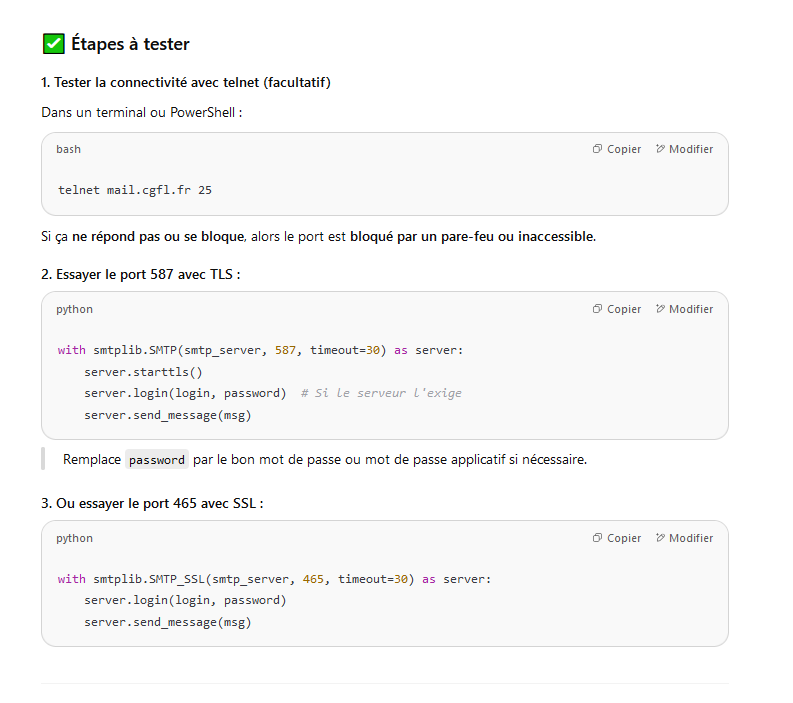

## <span style='background:Thistle'>8. Colonnes non modifiables</span> 

In [190]:
from openpyxl import Workbook
from openpyxl.styles import Protection
from datetime import datetime

# Créer le classeur et ajouter des données
wb = Workbook()
ws = wb.active
ws.title = "Tâches"

# En-têtes
headers = ['Date limite', 'Tâche', 'Responsable', 'Statut', 'RELECTURE']
ws.append(headers)

# Données simples
data = [
    [datetime(2025, 6, 10), 'Rapport', 'Alice', 'En cours', 'NON'],
    [datetime(2025, 6, 15), 'Analyse', 'Bob', 'À faire', 'OUI']
]

# Remplir les lignes
for row in data:
    ws.append(row)

# Appliquer le format de date
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
    for cell in row:
        cell.number_format = 'DD/MM/YYYY'

# 1. Déverrouiller colonnes B, C et D (colonnes 2 à 4)
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=2, max_col=4):
    for cell in row:
        cell.protection = Protection(locked=False)

# 2. Laisser les colonnes A et E verrouillées (c'est déjà le cas par défaut)

# 3. Protéger la feuille
ws.protection.sheet = True
# ws.protection.password = 'motdepasse123'  # optionnel, tu peux mettre None

# Sauvegarder le fichier
wb.save(rep_out+"fichier_protege.xlsx")

## <span style='background:Thistle'>9. Activer menu Formulaire?</span> 

In [2]:
import xlwings as xw

In [3]:
wb = xw.Book(r"C:\Temp\RECIST.xlsx")
vba_code = '''
Sub AjouterFormulaire()
    Dim uf As Object
    Set uf = ThisWorkbook.VBProject.VBComponents.Add(3) ' 3 = vbext_ct_MSForm
    uf.Properties("Caption") = "Mon Formulaire"
End Sub
'''

wb.api.VBProject.VBComponents("Module1").CodeModule.AddFromString(vba_code)
wb.macro("AjouterFormulaire")()

com_error: (-2147352567, 'Une exception s’est produite.', (0, 'Microsoft Excel', "L'accès par programme au projet Visual Basic n'est pas fiable\n", 'xlmain11.chm', 0, -2146827284), None)

com_error: (-2147352567, 'Une exception s’est produite.', (0, 'Microsoft Excel', "L'accès par programme au projet Visual Basic n'est pas fiable\n", 'xlmain11.chm', 0, -2146827284), None)

✅ Pour résoudre ce problème, tu dois activer manuellement une option de sécurité dans Excel :
🧭 Étapes à suivre dans Excel :

    Ouvre Excel.

    Va dans Fichier > Options.

    Clique sur Centre de gestion de la confidentialité dans le menu de gauche.

    Clique ensuite sur le bouton Paramètres du Centre de gestion de la confidentialité.

    Va dans Paramètres des macros.

    Coche cette option :

        ✅ Faire confiance à l’accès au modèle objet du projet VBA

    Redémarre Excel après avoir appliqué les changements.

🔁 Ensuite, relance ton script Python.

Cela devrait résoudre l’erreur.
🔒 Pourquoi cette sécurité existe ?

Microsoft désactive cet accès par défaut pour éviter l’exécution de macros malveillantes qui pourraient modifier du code VBA via script. Une fois activée dans un environnement de confiance, tu peux automatiser en toute liberté.